In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from fastai.vision import *
from fastai.metrics import error_rate

In [10]:
bs = 64

In [46]:
path_img = "/home/cjdavis/insight/instaloader/hair_photos/"

In [47]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/cjdavis/insight/instaloader/hair_photos/blonde_0.jpg'),
 PosixPath('/home/cjdavis/insight/instaloader/hair_photos/blonde_1.jpg'),
 PosixPath('/home/cjdavis/insight/instaloader/hair_photos/blonde_10.jpg'),
 PosixPath('/home/cjdavis/insight/instaloader/hair_photos/blonde_100.jpg'),
 PosixPath('/home/cjdavis/insight/instaloader/hair_photos/blonde_1000.jpg')]

In [48]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [77]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f2ce673ba60>
Traceback (most recent call last):
  File "/home/cjdavis/anaconda3/envs/insight/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/cjdavis/anaconda3/envs/insight/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/cjdavis/anaconda3/envs/insight/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/cjdavis/anaconda3/envs/insight/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/cjdavis/anaconda3/envs/insight/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


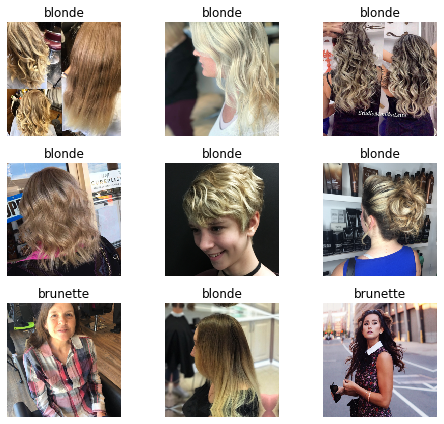

In [50]:
data.show_batch(rows=3, figsize=(7,6))

In [54]:
print(data.classes)
len(data.classes),data.c

['blonde', 'brunette', 'random']


(3, 3)

In [55]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [53]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [56]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.892164,0.390690,0.137184,08:14
1,0.591996,0.310420,0.117329,08:04
2,0.429379,0.270454,0.106498,08:06
3,0.338416,0.266397,0.110108,08:00


In [57]:
learn.save('stage-1')

In [58]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

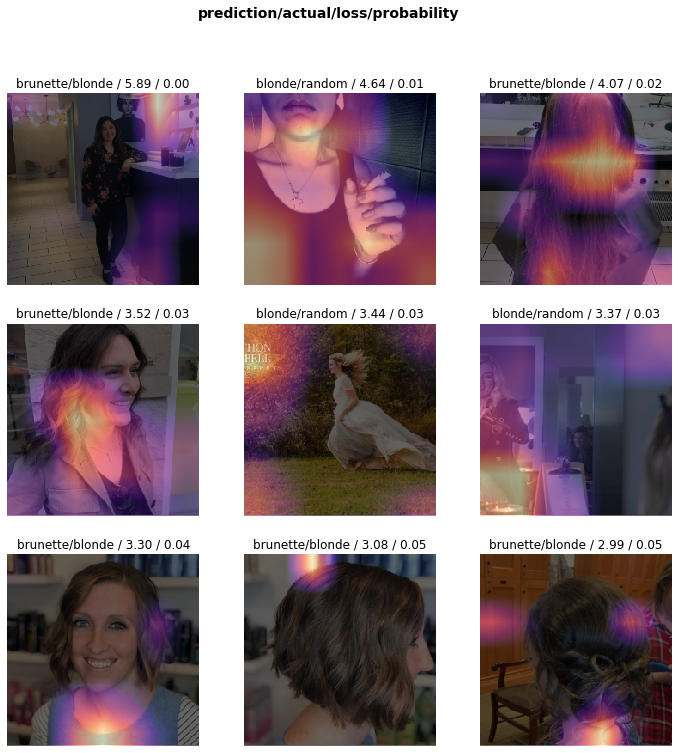

In [61]:
interp.plot_top_losses(9, figsize=(12,12))

In [40]:
doc(interp.plot_top_losses)

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = None , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

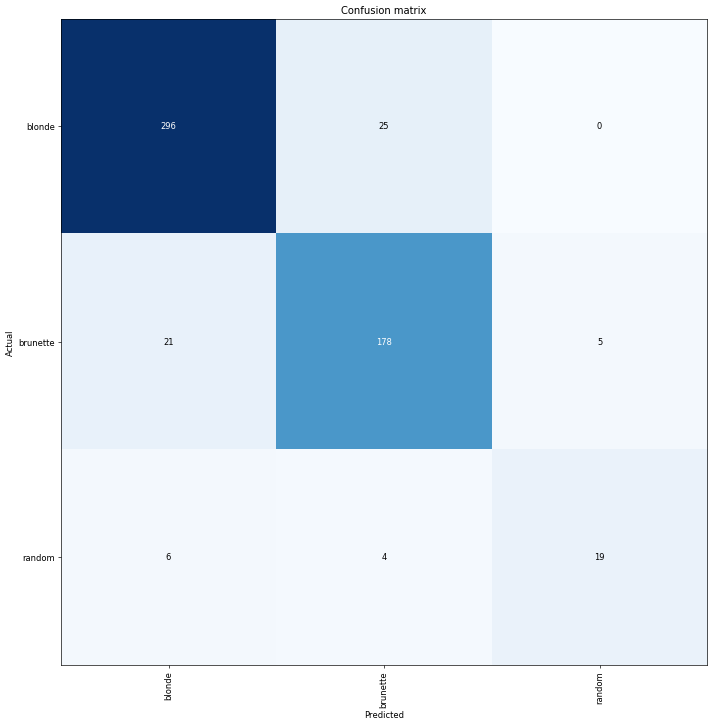

In [62]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
plt.savefig("confusion.png")

In [63]:
interp.most_confused(min_val=2)

[('blonde', 'brunette', 25),
 ('brunette', 'blonde', 21),
 ('random', 'blonde', 6),
 ('brunette', 'random', 5),
 ('random', 'brunette', 4)]

In [64]:
learn.unfreeze()

In [65]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.340738,0.288239,0.079422,10:17


In [66]:
learn.load('stage-1');

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


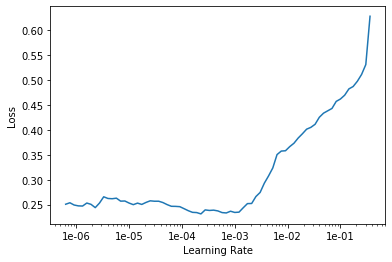

In [68]:
learn.recorder.plot()

In [69]:
learn.unfreeze()

In [70]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.309388,0.232501,0.093863,10:22
1,0.239681,0.197365,0.074007,10:14


# Now let's make some predictions!! #

In [97]:
path_test = "/home/cjdavis/insight/instaloader/ritualsalonatx/pictures/"
photo = path_test + "2019-01-03_17-44-05_UTC.jpg"
img = open_image(photo)

In [200]:
img = open_image("/home/cjdavis/Downloads/valerie.jpg")

In [185]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class, pred_idx, outputs)

blonde tensor(0) tensor([0.9493, 0.0399, 0.0107])


## It works for a picture of Val, but let's see how it does with pictures from ritual salon atx! ##

In [121]:
import os
import pandas as pd

In [124]:
salon_photos_path = "/home/cjdavis/insight/instaloader/ritualsalonatx/pictures/"
salon_photos_names = os.listdir(salon_photos_path)
salon_photos_path_list = []
for i in salon_photos_names:
    salon_photos_path_list.append(salon_photos_path)

In [126]:
salon_df = pd.DataFrame(list(zip(salon_photos_names, salon_photos_path_list)), columns = ["photo_path", "salon_path"])

In [127]:
salon_df.head()

,photo_path,salon_path
0,2015-09-01_17-49-19_UTC_profile_pic.jpg,/home/cjdavis/insight/instaloader/ritualsalona...
1,2019-01-03_17-44-05_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...
2,2019-01-05_21-59-14_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...
3,2019-01-07_18-10-55_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...
4,2019-01-10_00-32-51_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...


In [154]:
def classify_photos(row):
    file_location = row["salon_path"] + row["photo_path"]
    img = open_image(file_location)
    pred_class,pred_idx,outputs = learn.predict(img)
    output = str(pred_class) + " -- " +  str(pred_idx) + " -- " + str(outputs)
    return output

In [179]:
def get_prediction(row):
    prediction = row["classified"].split(" -- ")
    return prediction [0]
def get_confidence(row):
    classified = row["classified"].split(" -- ")
    classification = classified[1]
    class_number = -1
    for s in classification:
        if s.isdigit():
            class_number = int(s)
    confidence = classified[2]
    confidence = confidence.lstrip("tensor([")
    confidence = confidence.rstrip("])")
    confidence = confidence.split(", ")
    return float(confidence[class_number])

In [162]:
salon_df["classified"] = salon_df.apply(classify_photos, axis = 1)
salon_df["prediction"] = salon_df.apply(get_prediction, axis = 1)

In [180]:
salon_df["confidence"] = salon_df.apply(get_confidence, axis = 1)

In [182]:
salon_df.head(10)

,photo_path,salon_path,classified,prediction,confidence
0,2015-09-01_17-49-19_UTC_profile_pic.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"random -- tensor(2) -- tensor([5.2067e-04, 6.3...",random,0.99314
1,2019-01-03_17-44-05_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"blonde -- tensor(0) -- tensor([9.6002e-01, 3.9...",blonde,0.96002
2,2019-01-05_21-59-14_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"brunette -- tensor(1) -- tensor([8.5153e-04, 9...",brunette,0.99894
3,2019-01-07_18-10-55_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"blonde -- tensor(0) -- tensor([9.9885e-01, 4.2...",blonde,0.99885
4,2019-01-10_00-32-51_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"brunette -- tensor(1) -- tensor([3.4629e-05, 9...",brunette,0.99996
5,2019-01-11_21-29-26_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"blonde -- tensor(0) -- tensor([6.8311e-01, 3.1...",blonde,0.68311
6,2019-01-12_14-33-22_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"random -- tensor(2) -- tensor([0.0015, 0.0014,...",random,0.99710
7,2019-01-13_17-15-24_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"brunette -- tensor(1) -- tensor([0.2014, 0.794...",brunette,0.79490
8,2019-01-15_17-36-09_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"blonde -- tensor(0) -- tensor([9.9943e-01, 3.5...",blonde,0.99943
9,2019-01-17_00-49-25_UTC.jpg,/home/cjdavis/insight/instaloader/ritualsalona...,"blonde -- tensor(0) -- tensor([9.7955e-01, 1.9...",blonde,0.97955


# Load the data into a SQL database! #

In [191]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

/home/cjdavis/anaconda3/envs/insight/lib/python3.7/site-packages/sqlalchemy/sql/functions.py:68: SAWarning: The GenericFunction 'array_agg' is already registered and is going to be overriden.
  "is going to be overriden.".format(identifier))


In [195]:
f=open("db.txt", "r")
contents=0
if not(contents):
    contents = f.read()
username = contents.split("\n")[0]
password = contents.split("\n")[1]
dbname = 'photos_db'

In [196]:
engine = create_engine('postgres://%s:%s@localhost/%s'%(username,password, dbname))

In [197]:
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [198]:
salon_df.to_sql('salon_data_table', engine, if_exists='replace')